# INFORMACIÓN:

- __AUTOR:__ Miguel Puente Ajovín y Maximiliano Greco
- __FECHA:__ Agosto-2015
- __PYTHON:__ 3.k

# INDICE

- [INFORMACIÓN:](#INFORMACIÓN:)
- [DATOS](#DATOS)
- [FILTROS](#FILTROS)
- [FILTRO-HP](#FILTRO-HP)
- [FILTRO-QT:](#FILTRO-QT:)
- [VARIABLES-AUXILIARES:](#VARIABLES-AUXILIARES:)
- [MCO](#MCO)
- [EXPORTAR:](#EXPORTAR:)
- [EVOLUCIÓN:](#EVOLUCIÓN:)
- [Gráficos](#GRÁFICOS)
- [Markdown-Sintaxis:](#Markdown-Sintaxis:)
- [REGRESIÓN:](#REGRESIÓN:)
- [Python](#Python)
- [GIT-WORK-FLOW](#GIT-WORK-FLOW)


In [1]:
# python 3, compatibilidad:
# from __future__ import division, unicode_literals, print_function, absolute_import
import os
from datetime import datetime
from numpy import *
import statsmodels.api as sm
# import scipy as sp 

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
import seaborn as sns
# import prettyplotlib as ppl

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


# Cambiamos el directorio de trabajo a la raíz

In [2]:
dir_raiz = u'/Users/mmngreco/Documents/repos/okun_ccaa/'
os.chdir(dir_raiz)
UTF = 'utf-8'

!open .

In [3]:
from def_utils import *

In [4]:
sns.set(style="white", color_codes=True)
# sns.set(style="ticks", palette="Set2")
sns.despine()
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.multi_sparse', False)

In [5]:
hoy = datetime.today()
hoy = str(hoy).replace(' ','_')

# DATOS

- [🏠INDICE: ](#INDICE)
- [📈MCO](#MCO) 
- [📊datos](#DATOS)
- [🔨FILTROS](#FILTROS)
- [GRÁFICOS](#GRÁFICOS)

In [13]:
d_tipo = 'indices'
variables = ['empleo', 'paro', 'pib']

for v in variables:
    globals()['d'+v] = pd.read_excel('data_work/indices/%s.xls' % v, index_col=0)

dparo = dparo / 100
dpib = dpib.apply(log)

In [14]:
dparo = dparo.pct_change()
dparo.head()

,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,0.338959,0.130503,0.782123,0.355674,0.053809,0.147084,0.272017,0.245573,0.332412,0.598174,0.300546,0.210139,0.369272,0.581307,0.186149,0.659542,0.796707,0.738769
1979,0.243788,0.106052,0.353710,0.437102,0.108434,0.074861,0.227806,0.274882,0.272727,0.304898,0.395483,0.313687,0.339567,0.251809,0.318012,0.549218,0.319351,0.584689
1980,0.321946,0.257494,0.330374,0.145436,0.658385,0.159765,0.358799,0.256506,0.390411,0.530497,0.461799,0.111420,0.473181,0.207902,0.234370,0.409739,0.322736,0.255435
1981,0.229085,0.136990,0.368146,0.397859,0.245006,0.316900,0.380522,0.227515,0.308937,0.258533,0.373069,0.101418,0.220948,0.144994,0.277679,0.097725,0.269642,0.433862


In [15]:
dpib = log(dpib)
dpib = dpib.pct_change()
dpib.head()

,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
tiempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,-0.000251,-0.002090,-0.003385,0.001584,0.005065,0.001332,0.001916,-0.008064,-0.005473,-0.001562,0.003867,-0.004451,0.001731,0.000983,0.001518,0.004538,0.001967,0.005570
1982,0.002207,0.004555,0.007103,0.002443,0.004399,0.000627,0.002707,0.005445,0.001136,-0.001468,0.000196,0.000909,0.002674,0.004318,-0.000753,-0.001716,0.003191,0.005485
1983,0.003099,0.002893,0.004960,0.001992,0.007156,0.005527,0.003855,0.005705,0.000780,0.002625,0.002780,0.004176,0.000656,0.004849,0.002880,0.002952,-0.000642,0.004774


In [90]:
d_tipo = 'fedea'

horas = pd.read_excel('data_work/horas_efectivas_fedea.xlsx', index_col=0)
vab = pd.read_excel('data_work/vab_fedea.xlsx', index_col=0)

In [94]:
productividad = vab / horas

In [116]:
d = productividad.apply(log)
d.dropna(inplace=True)
hp_productividad = sm.tsa.filters.hpfilter(d)[0]

In [22]:
dwork = pd.concat([dparo, dpib], keys=variables[1:], axis=1)

/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/pandas/core/index.py:1414: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  "incomparable objects" % e, RuntimeWarning)


In [23]:
dwork.head()

,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib
,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,0.338959,0.130503,0.782123,0.355674,0.053809,0.147084,0.272017,0.245573,0.332412,0.598174,0.300546,0.210139,0.369272,0.581307,0.186149,0.659542,0.796707,0.738769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979,0.243788,0.106052,0.353710,0.437102,0.108434,0.074861,0.227806,0.274882,0.272727,0.304898,0.395483,0.313687,0.339567,0.251809,0.318012,0.549218,0.319351,0.584689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,0.321946,0.257494,0.330374,0.145436,0.658385,0.159765,0.358799,0.256506,0.390411,0.530497,0.461799,0.111420,0.473181,0.207902,0.234370,0.409739,0.322736,0.255435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,0.229085,0.136990,0.368146,0.397859,0.245006,0.316900,0.380522,0.227515,0.308937,0.258533,0.373069,0.101418,0.220948,0.144994,0.277679,0.097725,0.269642,0.433862,-0.000251,-0.00209,-0.003385,0.001584,0.005065,0.001332,0.001916,-0.008064,-0.005473,-0.001562,0.003867,-0.004451,0.001731,0.000983,0.001518,0.004538,0.001967,0.00557


In [24]:
dwork.tail()

,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib
,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
2011,0.078370,0.086335,0.157244,0.117684,0.075275,0.034585,0.102361,0.060184,0.092068,0.084354,0.051078,0.088947,0.130541,0.040585,0.088251,0.092003,0.138454,0.191452,-0.000664,-0.000766,-0.001098,-0.000822,0.000316,-0.000442,-0.001990,0.000232,-0.000544,-0.001784,-0.001450,-0.000965,-0.002003,0.000625,-0.000437,0.000663,-0.000590,-0.001389
2012,0.156672,0.138379,0.087026,0.218426,0.059192,0.111570,0.159065,0.179564,0.242229,0.176753,0.129352,0.316366,0.187132,0.134937,0.097825,0.253140,0.239484,0.203029,-0.002363,-0.003130,-0.004184,-0.004095,-0.000527,-0.001564,-0.002035,-0.003543,-0.004589,-0.002167,-0.003322,-0.003745,-0.002660,-0.000416,-0.002331,-0.003018,-0.001914,-0.003072
2013,0.053142,0.050444,0.148143,0.104918,-0.037937,0.032195,0.161354,0.101190,0.057419,0.031674,0.034623,0.019902,0.068231,0.065833,0.053250,0.116423,0.064180,-0.027496,-0.001381,-0.001263,-0.000817,-0.003009,-0.000530,-0.000566,-0.002704,-0.002197,-0.001043,-0.001281,-0.000823,-0.001136,-0.001112,-0.001685,-0.001476,-0.001146,-0.002203,-0.001467
tiempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001497,0.001493,0.001858,0.001016,0.002000,0.002356,0.001242,0.001717,0.001275,0.001514,0.002218,0.002372,0.000620,0.001059,0.002265,0.002169,0.001477,0.002694


In [25]:
dwork.dropna(axis=0, how='any', inplace=True)

In [26]:
dwork.head()

,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib
,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1981,0.229085,0.136990,0.368146,0.397859,0.245006,0.316900,0.380522,0.227515,0.308937,0.258533,0.373069,0.101418,0.220948,0.144994,0.277679,0.097725,0.269642,0.433862,-0.000251,-0.002090,-0.003385,0.001584,0.005065,0.001332,0.001916,-0.008064,-0.005473,-0.001562,0.003867,-0.004451,0.001731,0.000983,0.001518,0.004538,0.001967,0.005570
1982,0.129366,0.037509,0.035835,0.166348,0.177739,0.122631,0.204121,0.172090,-0.015591,0.244235,0.257454,0.053006,0.228758,0.010277,0.217928,0.026861,0.155902,0.475344,0.002207,0.004555,0.007103,0.002443,0.004399,0.000627,0.002707,0.005445,0.001136,-0.001468,0.000196,0.000909,0.002674,0.004318,-0.000753,-0.001716,0.003191,0.005485
1983,0.093563,0.091296,0.120368,0.013679,0.185824,0.048991,0.015301,0.115155,0.025487,0.100235,0.029973,-0.059543,0.315160,0.151897,0.087504,0.159753,0.079824,0.024102,0.003099,0.002893,0.004960,0.001992,0.007156,0.005527,0.003855,0.005705,0.000780,0.002625,0.002780,0.004176,0.000656,0.004849,0.002880,0.002952,-0.000642,0.004774
1984,0.158852,0.289682,0.110177,0.127024,0.008616,0.169676,0.267896,0.179237,0.155690,0.031435,0.128710,0.622419,0.173407,0.160754,0.014288,0.045916,0.101326,0.227575,0.002042,0.001293,0.006125,0.001443,0.007452,-0.004697,0.001884,0.003264,0.004664,0.002968,0.002868,0.020040,0.001205,0.001495,0.001271,-0.000440,-0.004444,0.003188
1985,0.068352,0.026725,0.135945,0.174808,-0.017975,0.148753,-0.021426,0.136200,0.020123,0.026567,0.066957,0.018004,0.118914,0.087814,0.216489,0.154498,0.065502,0.264424,0.003591,0.005995,0.001943,0.007771,0.006386,-0.000140,0.000636,0.007264,0.007434,0.001463,0.003428,0.007092,0.001246,0.003273,0.001556,0.002504,0.001791,0.009049


- [🏠INDICE: ](#INDICE)
- [📈MCO](#MCO) 
- [📊datos](#DATOS)
- [🔨FILTROS](#FILTROS)

## VARIABLES AUXILIARES:

In [28]:
regiones = dwork['pib'].columns # variable con los nombres de las ccaa
foot = u'FUENTE: Datos obtenidos de la web: INE.es, \nElaboración propia: Maximiliano Greco, @mmngreco' 

# FILTROS

- [🏠INDICE: ](#INDICE)
- [📈MCO](#MCO) 
- [📊datos](#DATOS)
- [🔨FILTROS](#FILTROS)

## FILTRO HP

In [46]:
#for i in range(5):

id_x = 1  
#               0         1        2  # variable a filtrar
variables = ['empleo', 'paro', 'pib']

print('{:^60}'.format('FILTRO HP'))
print('HOJA %s' % d_tipo)

data = dwork.copy()

for v in variables:
    d = data[v].dropna(axis=0, how='all')
    d = d.iloc[:]

    ciclo, tendencia = sm.tsa.filters.hpfilter(d)
    globals()['hp_%s' % v] = ciclo # variable output
    print('Variable sin tendencia HP creada: %s' % ('hp_%s' % v))
    print(ciclo.head(2).ix[:,:2])
    print(ciclo.tail(2).ix[:,:2])
    print('')

                         FILTRO HP                          
HOJA hp-filter
Variable sin tendencia HP creada: hp_empleo
        España  Andalucía
1980  9.749476  10.908162
1981  6.001890   7.321642
         España  Andalucía
2012 -13.964312 -18.924062
2013 -19.875606 -26.092618

Variable sin tendencia HP creada: hp_paro
        España  Andalucía
1980 -0.057198  -0.065870
1981 -0.032784  -0.046333
        España  Andalucía
2012  0.071530   0.091395
2013  0.080664   0.105137

Variable sin tendencia HP creada: hp_pib
        España  Andalucía
1980  0.037168   0.037914
1981  0.006199  -0.008789
        España  Andalucía
2012 -0.080315  -0.095502
2013 -0.113655  -0.127797



In [47]:
hps = crear_df([hp_empleo, hp_paro, hp_pib])

In [48]:
x = 'paro'
y = 'pib'
s, b, m = estimar_mco(hps, 
                      endogena=y, 
                      exogena=x, 
                      regiones=regiones)

res = resumen_mco(b, 0)
res['sig'] = res['pv_b1'] < 0.05
res.ix[:,2:].sort_index()

,b1,pv_b1,R2,sig
Andalucía,-0.733269,8.793503e-12,0.771390,True
Aragón,-0.825737,1.652166e-07,0.580554,True
"Asturias, Principado de",-0.673005,5.742586e-06,0.479227,True
"Balears, Illes",-0.696296,1.538186e-06,0.519306,True
Canarias,-0.713850,5.447421e-11,0.744056,True
Cantabria,-0.918157,4.198093e-09,0.665285,True
Castilla - La Mancha,-0.875911,2.426696e-06,0.505778,True
Castilla y León,-0.603721,2.913676e-05,0.425488,True
Cataluña,-0.979750,9.877671e-16,0.870051,True
Comunitat Valenciana,-0.976168,6.587528e-16,0.873287,True


In [25]:
#hps.to_csv('data_work/filtrado/max/hp_data.csv')

# FILTRO QT:

- [🏠INDICE: ](#INDICE)
- [📈MCO](#MCO) 
- [📊datos](#DATOS)
- [🔨FILTROS](#FILTROS)

In [55]:
variables

['empleo', 'paro', 'pib']

In [56]:

for i in range(3):
    id_v = i
    v = variables[id_v]

    d = dwork[v]
#    d = data[v].dropna(how='all', axis=0)
#    d = d.iloc[:2005 - d.index.min()]

    globals()['qt_%s' % v] = sm.tsa.tsatools.detrend(d, order=2, axis=0)
    df = globals()['qt_%s' % v]

    globals()['qt_%s' % v] = DataFrame(df, index=d.index, columns=d.columns)
    print('Variable sin tendencia creada: qt_%s' % v)

    df = globals()['qt_%s' % v]


Variable sin tendencia creada: qt_empleo
Variable sin tendencia creada: qt_paro
Variable sin tendencia creada: qt_pib


In [57]:
qts = crear_df([qt_empleo, qt_paro, qt_pib])
qts.head(2)

Variables,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib
Regiones,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1980,9.469620,11.356731,6.635463,4.710899,11.247371,19.182266,8.257627,5.329412,4.519214,13.171538,14.218189,5.939221,0.748556,8.396430,12.631791,10.358280,10.175851,9.774994,-0.074129,-0.078288,-0.070788,-0.066791,-0.066940,-0.11194,-0.059240,-0.055907,-0.059861,-0.094450,-0.090996,-0.061826,-0.033464,-0.057369,-0.081004,-0.062716,-0.076935,-0.079231,0.064865,0.072920,0.045465,0.023703,0.033775,0.085100,0.047243,0.058773,0.081509,0.106688,0.059915,0.052353,0.033226,0.044989,0.071256,0.051404,0.044316,0.040982
1981,5.809931,7.701227,2.807660,2.766801,5.599840,11.876366,6.674252,3.490160,0.912790,8.613390,7.779251,4.543193,-0.460619,5.731412,7.643783,6.487976,6.151980,7.493203,-0.045703,-0.055805,-0.033444,-0.035328,-0.040861,-0.06642,-0.035302,-0.039095,-0.022254,-0.054307,-0.050423,-0.050719,-0.028542,-0.034630,-0.051378,-0.042602,-0.043206,-0.053056,0.027591,0.018302,-0.015303,0.006339,0.013981,0.054339,0.031669,-0.028382,0.008458,0.055945,0.050704,-0.024361,0.026858,0.012097,0.050569,0.052609,0.040639,0.035636


In [58]:
x = 'paro'
y = 'pib'

s, b, m = estimar_mco(qts, 
                      endogena=y, 
                      exogena=x, 
                      regiones=regiones)

res = resumen_mco(b, 0)
res['sig'] = res['pv_b1'] < 0.05
res.ix[:,2:].sort_index()

,b1,pv_b1,R2,sig
Andalucía,-0.696537,1.866433e-14,0.843988,True
Aragón,-0.739129,2.109725e-07,0.574229,True
"Asturias, Principado de",-0.622985,8.693528e-07,0.535740,True
"Balears, Illes",-0.536509,8.962328e-11,0.736049,True
Canarias,-0.669863,2.165038e-12,0.790415,True
Cantabria,-0.925254,7.590385e-12,0.773465,True
Castilla - La Mancha,-0.783539,7.203901e-06,0.472019,True
Castilla y León,-0.562315,2.068984e-06,0.510550,True
Cataluña,-0.967668,5.534263e-17,0.891394,True
Comunitat Valenciana,-0.950541,2.287593e-17,0.897209,True


In [29]:
#qts.to_csv('data_work/filtrado/max/qt_data.csv')

# MCO

# RESUMEN

- [🏠INDICE: ](#INDICE)
- [📈MCO](#MCO) 
- [📊datos](#DATOS)
- [🔨FILTROS](#FILTROS)

In [31]:
data = dwork
y = 'pib'
x = 'paro'
s, p, m = estimar_mco(data, exogena=x, endogena=y, regiones=regiones)
print(d_tipo)
resumen_mco(p, 1)

indices


,$β_0$,$pv_{β_0}$,$β_1$,$pv_{β_1}$,$R^2$
Extremadura,0.003072,7.125861e-04,0.002546,5.851442e-01,0.009721
"Rioja, La",0.003506,1.905993e-04,-0.003883,2.317567e-01,0.045796
Cantabria,0.002654,2.251633e-04,-0.009359,6.537911e-03,0.215234
Castilla y León,0.002587,1.757861e-05,-0.010031,5.560385e-03,0.222701
"Asturias, Principado de",0.002504,1.262161e-05,-0.008773,1.595321e-03,0.278582
"Balears, Illes",0.003822,1.826892e-09,-0.007213,1.149089e-03,0.292744
Castilla - La Mancha,0.003534,4.142090e-06,-0.012431,1.038953e-03,0.297048
Galicia,0.002771,3.324955e-07,-0.010798,2.351874e-04,0.358004
"Navarra, Comunidad Foral de",0.003133,1.228320e-06,-0.011863,2.173724e-04,0.361105
Canarias,0.003451,2.302900e-07,-0.012625,1.333504e-04,0.380046


# EXPORTAR:

In [43]:
# guardar_mco(sumrz_paro, 'modelos_u')

# guardar_mco(sumrz_empleo, 'modelos_l')

In [45]:
hps.head()

Variables,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib
Regiones,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1980,9.749476,10.908162,7.396422,7.137203,14.958039,16.220484,11.191608,6.240390,6.501349,12.048460,12.791160,5.829455,2.560517,10.601136,12.984344,10.042171,9.655221,11.979132,-0.057198,-0.065870,-0.048326,-0.060606,-0.038997,-0.077002,-0.060230,-0.051650,-0.034379,-0.067311,-0.065907,-0.056426,-0.035878,-0.040658,-0.058908,-0.037978,-0.073914,-0.059340,0.037168,0.037914,0.017202,-0.002250,-0.030038,0.045593,0.019499,0.032072,0.064792,0.068810,0.025513,0.013177,0.030031,0.021886,0.054599,0.032797,0.040331,-0.002204
1981,6.001890,7.321642,3.368380,4.620609,8.415928,9.589542,8.922151,4.184189,2.376687,7.748380,6.654347,4.453050,0.896570,7.375063,7.854236,6.245353,5.766756,9.177119,-0.032784,-0.046333,-0.016261,-0.030677,-0.019476,-0.039866,-0.036141,-0.035910,-0.002524,-0.033665,-0.031238,-0.046637,-0.030354,-0.021809,-0.034435,-0.023784,-0.041129,-0.037994,0.006199,-0.008789,-0.037357,-0.014001,-0.035360,0.024078,0.010228,-0.049168,-0.004511,0.027050,0.024088,-0.054999,0.024350,-0.005958,0.037714,0.038227,0.037576,0.002386
1982,3.816419,5.822016,2.991771,1.272704,5.165860,5.025660,2.784465,2.198551,2.938529,2.995777,3.005551,3.861393,1.559381,6.962058,5.990948,4.391640,2.665613,6.192579,-0.016334,-0.043180,-0.011667,-0.014610,-0.001832,-0.021831,-0.019389,-0.021513,-0.005747,0.005997,0.001573,-0.043263,-0.021882,-0.019635,-0.009849,-0.017667,-0.017173,-0.003736,-0.007489,-0.008862,-0.018386,-0.019624,-0.044983,-0.002414,0.006616,-0.036384,-0.027632,-0.014052,-0.003236,-0.085659,0.025382,-0.010191,0.004791,-0.000585,0.043553,0.006925
1983,1.985379,3.915192,1.932710,1.066073,5.058441,3.974515,1.539234,1.330755,2.688793,-1.303340,1.520328,6.230635,2.579670,3.652177,0.632344,1.736630,1.077601,4.018814,-0.003117,-0.028591,0.003473,-0.016123,0.019974,-0.014650,-0.021689,-0.010879,-0.003251,0.027365,0.005185,-0.058889,-0.003647,0.003153,0.000856,0.006388,-0.003099,-0.002155,-0.014814,-0.020433,-0.013870,-0.028343,-0.034153,0.005824,0.011320,-0.021259,-0.053294,-0.026628,-0.012203,-0.093431,0.012103,-0.010296,-0.002569,-0.006309,0.022275,0.006833
1984,-1.783373,-4.830773,-2.148676,-1.014759,3.350118,-0.140127,0.070393,-1.389800,-0.883484,-3.813739,-1.508600,-5.518688,2.050005,-0.085054,0.418805,-2.532399,-1.206321,-3.353306,0.022958,0.032381,0.019107,-0.001700,0.021253,0.016239,0.008056,0.010210,0.017742,0.036322,0.026159,0.037776,0.008157,0.030882,0.000721,0.016305,0.016551,0.022562,-0.029598,-0.043354,-0.000433,-0.040882,-0.020048,-0.058829,0.002011,-0.022943,-0.051861,-0.036814,-0.020471,0.013041,0.002646,-0.034321,-0.021391,-0.036235,-0.026087,-0.004522


# EVOLUCIÓN:

- [🏠INDICE: ](#INDICE)
- [📈MCO](#MCO) 
- [📊datos](#DATOS)
- [🔨FILTROS](#FILTROS)

In [34]:
d_tipo = 'log~tasa'
data = dwork

desde = data.index.min()
hasta = desde + 10
fin = data.index.max()

id_x = 0 

x = 'paro'
y = 'pib'

print('VARIABLE:', y.upper(), '~', x.upper())
print('ESTIMACIÓN:\n    Desde:\t%s\n    Hasta:\t%s\n    Fin:\t%s\nAñadiendo un año más a la muestra.' % (desde, hasta, fin))

b0_evolucion = DataFrame(columns=regiones)
b1_evolucion = DataFrame(columns=regiones)
# umbral_evolucion = DataFrame(columns=regiones)


while hasta <= fin:
    s, p, m = estimar_mco(data.iloc[hasta - desde - 10 :hasta - desde + 1], 
                          endogena=y, 
                          exogena=x, 
                          regiones=regiones)

    b0_evolucion.loc[hasta] = resumen_mco(p, 0).b0.T
    b1_evolucion.loc[hasta] = resumen_mco(p, 0).b1.T

    if hasta == 2004: 
        print('MCO 2004:\n')
        print(resumen_mco(p, 0)[['b0', 'b1']])

    hasta += 1

evolucion_okun = crear_df([b0_evolucion, b1_evolucion], keys=['b0', 'b1'])
evolucion_okun.head()

VARIABLE: PIB ~ PARO
ESTIMACIÓN:
    Desde:	1981
    Hasta:	1991
    Fin:	2013
Añadiendo un año más a la muestra.
MCO 2004:

                                   b0        b1
Aragón                       0.003752 -0.000919
Extremadura                  0.003559 -0.000968
Rioja, La                    0.003687 -0.000861
Castilla y León              0.002798 -0.002329
Galicia                      0.003330 -0.002758
Castilla - La Mancha         0.003800 -0.005050
Andalucía                    0.004068 -0.005956
Asturias, Principado de      0.002717 -0.003328
Murcia, Región de            0.004231 -0.009767
Madrid, Comunidad de         0.004238 -0.006781
Navarra, Comunidad Foral de  0.004055 -0.005644
Cantabria                    0.003302 -0.007108
País Vasco                   0.002624 -0.017611
España                       0.003652 -0.008375
Canarias                     0.003191 -0.014364
Comunitat Valenciana         0.003619 -0.012797
Cataluña                     0.003786 -0.006490
Balears, Il

/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


Variables,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1
Regiones,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1991,0.004626,0.005188,0.004702,0.003448,0.006038,0.005723,0.003459,0.003847,0.004768,0.004059,0.004419,0.004088,0.003154,0.004827,0.004487,0.003556,0.002705,0.005455,-0.019165,-0.020103,-0.013106,-0.001652,-0.000667,-0.030546,-0.004832,-0.012310,-0.021717,-0.021127,-0.007120,0.020918,-0.009082,-0.015132,-0.019433,-0.015786,-0.012893,-0.001042
1992,0.004559,0.005256,0.004871,0.003462,0.005851,0.006006,0.003374,0.003815,0.004936,0.004074,0.004248,0.004627,0.003112,0.004660,0.004468,0.002877,0.002415,0.005308,-0.019582,-0.017008,-0.007452,0.003423,-0.002286,-0.050161,-0.005464,0.002372,-0.006761,-0.020876,-0.015538,0.021991,-0.007992,-0.015845,-0.023834,-0.021567,-0.027977,-0.002764
1993,0.004510,0.005067,0.004468,0.003343,0.005838,0.006055,0.003166,0.003708,0.005113,0.004353,0.004109,0.004367,0.002889,0.004666,0.004469,0.003258,0.002221,0.004731,-0.022398,-0.022185,-0.011808,-0.007493,-0.007586,-0.048107,-0.010664,-0.001236,-0.023455,-0.015729,-0.019990,0.019561,-0.009800,-0.016117,-0.023787,-0.020840,-0.035289,-0.004689
1994,0.004430,0.004965,0.004144,0.003392,0.005363,0.005220,0.003158,0.003516,0.005160,0.004427,0.004093,0.003900,0.003014,0.004504,0.004333,0.003054,0.002257,0.004574,-0.022868,-0.022172,-0.012590,-0.008074,-0.008439,-0.042487,-0.008907,-0.002832,-0.023091,-0.015442,-0.020061,0.020100,-0.011552,-0.017061,-0.023709,-0.024079,-0.035142,-0.005176
1995,0.004131,0.004770,0.003738,0.003246,0.004869,0.004730,0.002996,0.003342,0.004761,0.004378,0.003830,0.004264,0.002774,0.004434,0.004122,0.003118,0.002454,0.004407,-0.023241,-0.036115,-0.013035,-0.005730,-0.006822,-0.027211,-0.010336,-0.002297,-0.026840,-0.014970,-0.019990,-0.033471,-0.009897,-0.016825,-0.020951,-0.021935,-0.030100,-0.004689


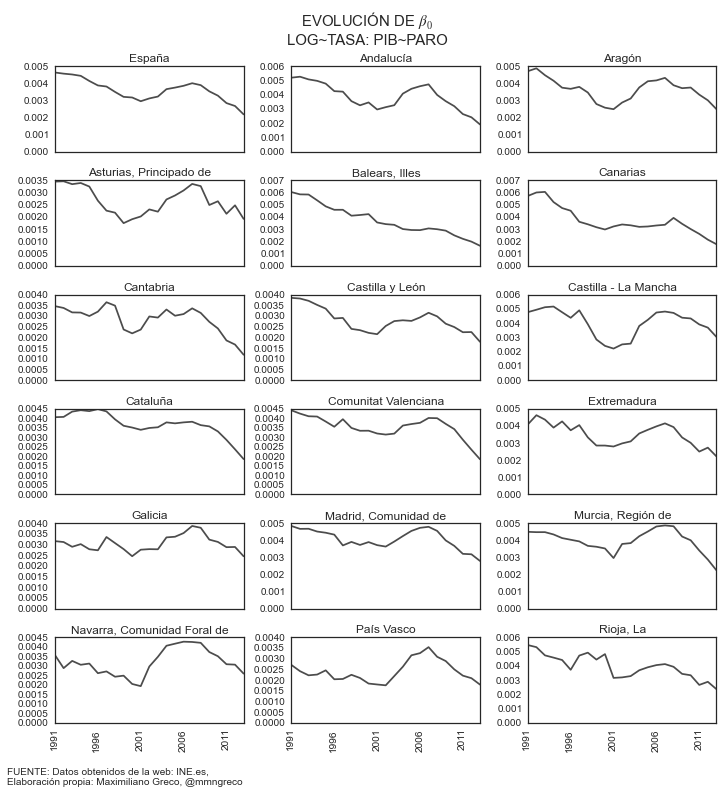

In [37]:
fig = plt.figure(figsize=(10,10))
x = 'paro'
y = 'pib'
p = 'b0'

ttl= 'EVOLUCIÓN DE $β_%s$\n%s: %s~%s' % (p[-1],d_tipo.upper(), y.upper(), x.upper())
file_name = 'evolucion_%s_%s_%s_%s.png' % (d_tipo, y, p, hoy)

for i, reg in enumerate(regiones):
    ax = fig.add_subplot(6,3,i+1)
    plt.axhline(y=0, color='black', linewidth=1)
    evolucion_okun[p][reg].plot(ax=ax, label=reg, sharex=True, color='black', alpha=0.7)
    plt.title(reg)
    plt.xticks(evolucion_okun.index[::5], evolucion_okun.index[::5], rotation=90)
    plt.xlim(evolucion_okun.index.min(), evolucion_okun.index.max())

plt.gcf().text(0, -0.03, "%s" % foot, fontsize=10, transform=(1,1))
plt.suptitle(x=0.5, y=1.05, t=ttl, fontsize=15)
plt.tight_layout()
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

- [🏠INDICE: ](#INDICE)
- [📈MCO](#MCO) 
- [📊datos](#DATOS)
- [🔨FILTROS](#FILTROS)

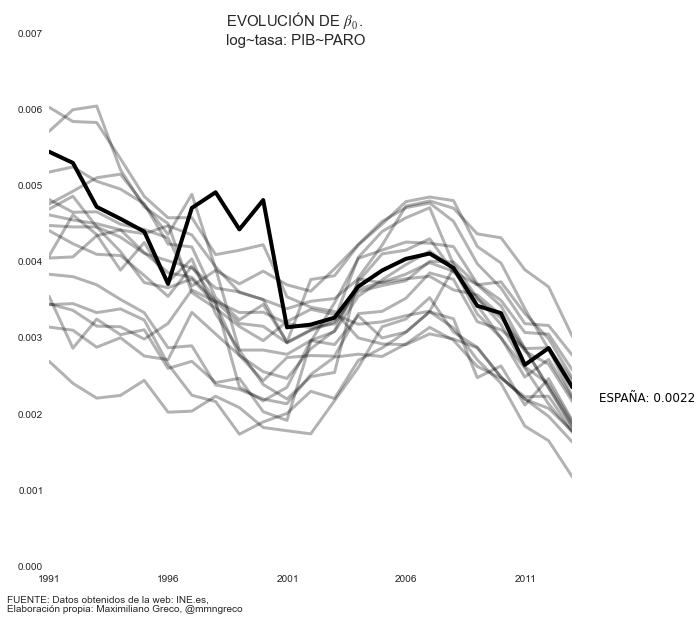

In [38]:
fig = plt.figure(figsize=(8,8), dpi=200)
ttl= 'EVOLUCIÓN DE $β_%s$.\n%s: %s~%s' % (p[-1],d_tipo, y.upper(), x.upper())
file_name = 'evolucion_%s_%s_%s_%s_todas.png' % (d_tipo, y, p, hoy)

c = '#' + '000000'
c1 = '#' + '000000'

for i, reg in enumerate(regiones):
    ax = fig.add_subplot(111)
    plt.axhline(y=0, color='black', linewidth=1)
    evolucion_okun[p][reg].plot(ax=ax, label=reg, alpha=0.3, linewidth=3, color=c1)

evolucion_okun[p][reg].plot(ax=ax, label=reg, alpha=1, color=c, linewidth=4)

plt.xticks(evolucion_okun.index[::5])
plt.xlim(evolucion_okun.index.min(), evolucion_okun.index.max())

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.axes.get_xaxis().set_visible(True)
ax.axes.get_yaxis().set_visible(True)

ax.tick_params(axis='both',
               which='both',
               bottom='off',
               top='off',
               left='off',
               labelbottom='on',
               labelleft='on')

plt.text(2014.1, 
         evolucion_okun[p]['España'].values[-1], 
         'ESPAÑA: {:.4f}'.format(evolucion_okun[p]['España'].values[-1]),
         fontsize=12,
         family='bold',
         color=c)



plt.gcf().text(0, 
               -0.03, 
               "%s" % foot, 
               fontsize=10, 
               transform=(1,1))

plt.suptitle(x=0.5, y=1.02, t=ttl, fontsize=15)

plt.tight_layout()
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=200)


In [85]:
d = evolucion_okun.b1['España'].loc[2005:]
d
#d[d == d.max()]

2005   -0.807432
2006   -0.880189
2007   -0.961223
2008   -1.037815
2009   -0.800327
2010   -0.635290
2011   -0.677711
2012   -0.799268
2013   -0.909468
Name: España, dtype: float64

- [🏠INDICE: ](#INDICE)
- [📈MCO](#MCO) 
- [📊datos](#DATOS)
- [🔨FILTROS](#FILTROS)

# GRÁFICOS

In [49]:
# con matplotlib
# fig = plt.figure(figsize=(15,15))
# data.du.boxplot(rot=90, ax=fig.add_subplot(311))
# data.dl.boxplot(rot=90, ax=fig.add_subplot(312))
# data.dy.boxplot(rot=90, ax=fig.add_subplot(313))

# plt.tight_layout()

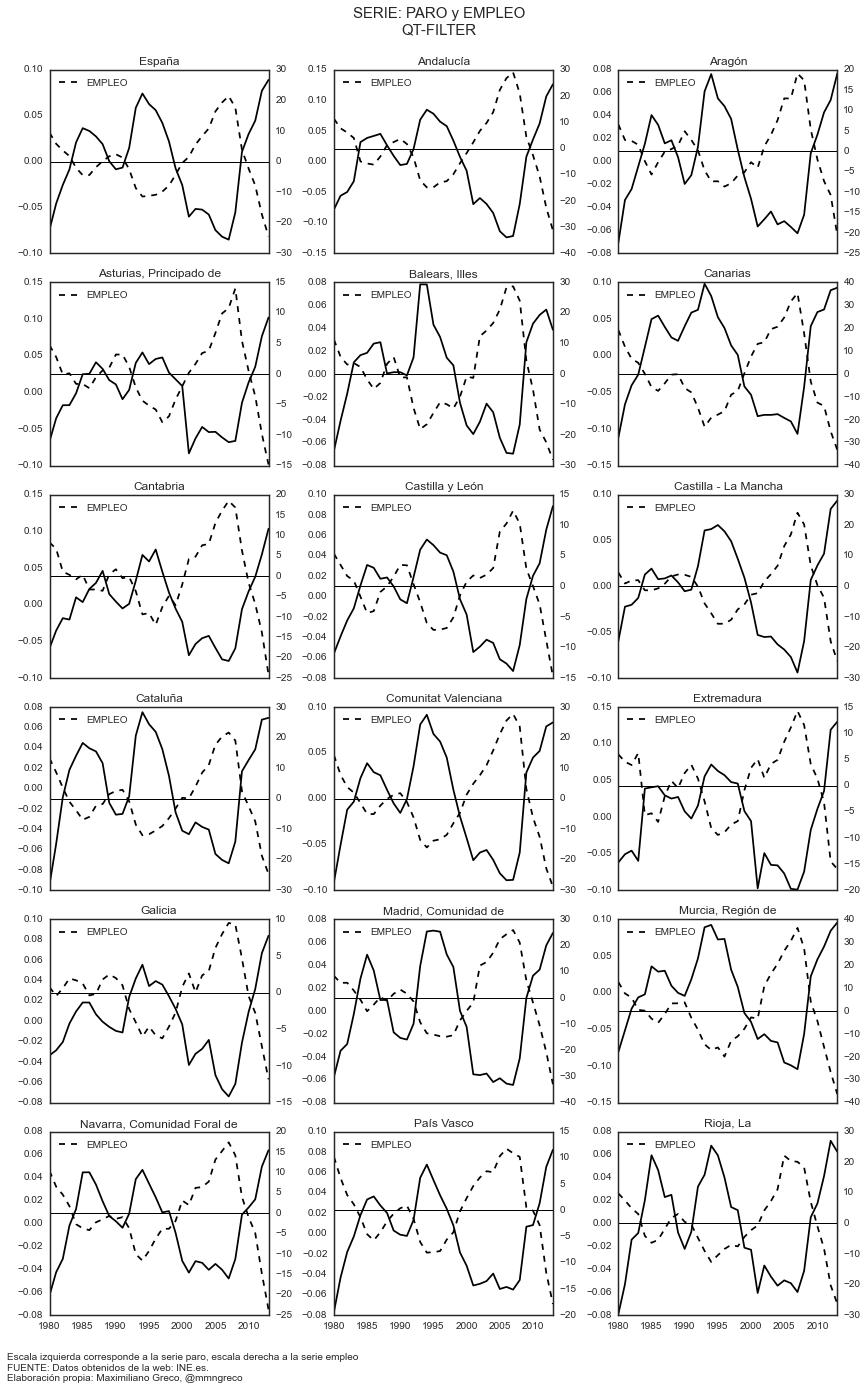

In [228]:
# PARAMETROS DEL GRÁFICO
id_x = 0
data = qts
d_tipo = 'qt-filter'
x = ['paro', 'empleo']
foot1 = '''Escala izquierda corresponde a la serie %s, escala derecha a la serie %s
FUENTE: Datos obtenidos de la web: INE.es.
Elaboración propia: Maximiliano Greco, @mmngreco''' % (variables[1], variables[0])

c = 'black'
ttl = 'SERIE: %s y %s\n%s' % (x[0].upper(), x[1].upper(), d_tipo.upper())
file_name = 'serie_%s_%s_%s_%s.png' % (x[0], x[1], d_tipo.upper(), hoy)

######## 

fig = plt.figure(figsize=(12,18))

for i, reg in enumerate(regiones):
    ax = fig.add_subplot(len(regiones)/3, 3, i + 1)
    data[x[0]][reg].plot(ax=ax, label=x[0].upper(), color=c, sharex=True)
    data[x[1]][reg].plot(ax=ax, linestyle='--', label=x[1].upper(), secondary_y=True, color=c, sharex=True)
    plt.axhline(y=0, color='black', linewidth=1, axes=ax)
    plt.title(reg)
    plt.legend(loc='upper left')

plt.gcf().text(0, -0.03, "%s" % foot1, fontsize=10, transform=(1,1))
plt.tight_layout()
plt.suptitle(t=ttl, fontsize=15, x=0.5, y=1.03)
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=200)

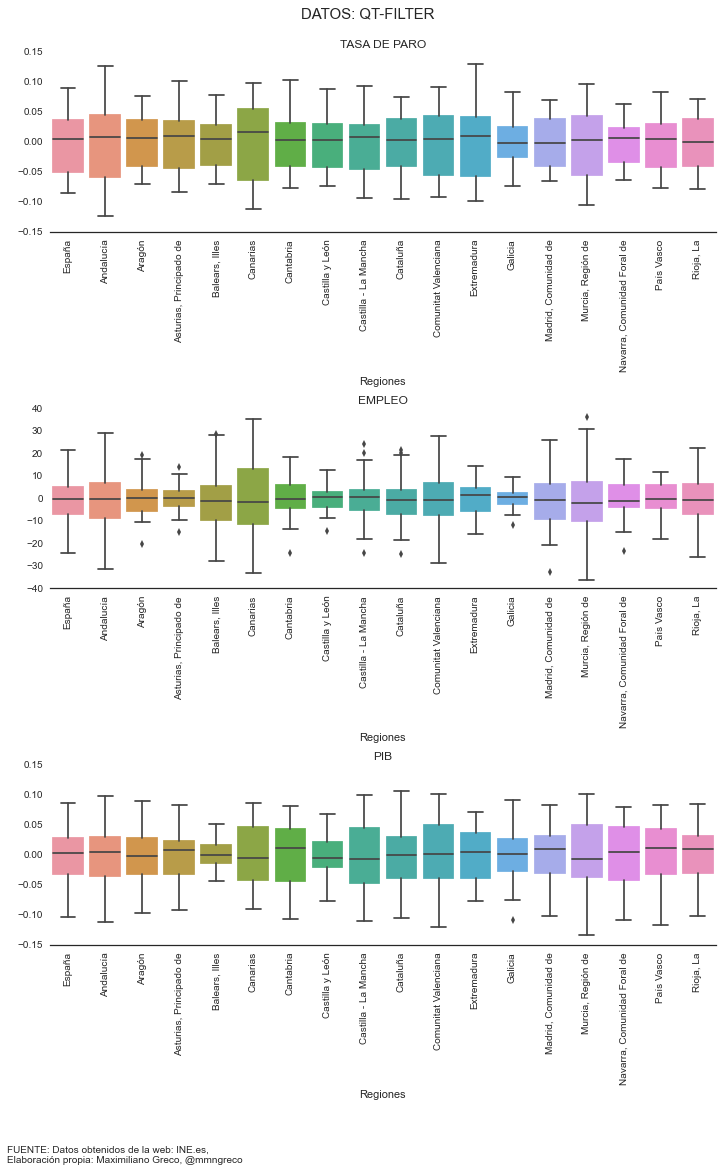

In [229]:
# i = id_xls
ttl = 'DATOS: %s' % (d_tipo.upper())
file_name = 'boxplot_%s_%s.png' % (d_tipo.upper(), hoy)


# con seaborn
fig = plt.figure(figsize=(10,15))
sns.set_palette('Greys')

g1 = sns.boxplot(data=data.paro, fliersize=5, width=.8, ax=fig.add_subplot(311))
g1.set_xticklabels(data.paro.columns, rotation=90)
g1.set_title('TASA DE PARO')

g2 = sns.boxplot(data=data.empleo, fliersize=5, width=.8, ax=fig.add_subplot(312))
g2.set_xticklabels(data.empleo.columns, rotation=90)
g2.set_title('EMPLEO')

g3 = sns.boxplot(data=data.pib, fliersize=5, width=.8, ax=fig.add_subplot(313))
g3.set_xticklabels(data.pib.columns, rotation=90)
g3.set_title('PIB')

sns.despine(left=True)

plt.suptitle(x=0.5, y=1.02, t=ttl, fontsize=15)
plt.gcf().text(0, -0.05, "%s" % foot, fontsize=10, transform=(1,1))
plt.tight_layout()

plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

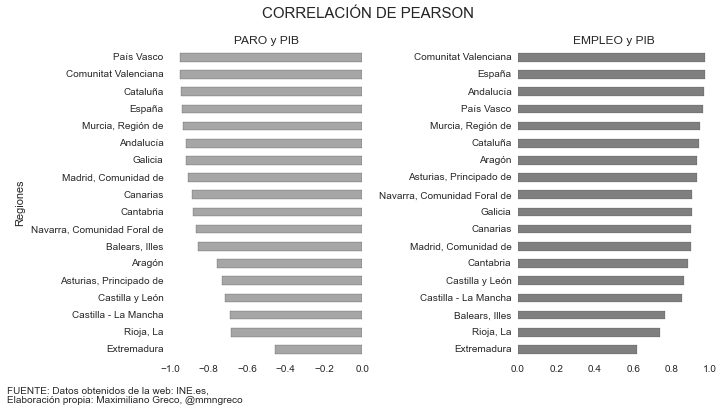

In [230]:
ttl = 'CORRELACIÓN DE PEARSON\n%s' % d_tipo.upper()
file_name = 'corr_%s_%s.png' % (d_tipo.upper(), hoy)

x = ['paro', 'empleo']
y = 'pib'

# ----------------------------

plt.figure(figsize=(10,5))

axs = [plt.subplot(121)]
data[x[0]].corrwith(data[y], axis=0).order(ascending=False).plot(kind='barh', color='grey', alpha=0.7)
plt.gca().set_title('%s y %s' % (x[0].upper(), y.upper()))

axs += [plt.subplot(122)]
data[x[1]].corrwith(data[y], axis=0).order(ascending=True).plot(kind='barh', color='black', alpha=0.5)
plt.gca().set_title('%s y %s' % (x[1].upper(), y.upper()))

plt.suptitle('CORRELACIÓN DE PEARSON', fontsize=15, x=0.5, y=1.05)

# Quitar las líneas del marco del eje.

for i, ax in enumerate(axs):
    if i == 1:
        ax.axes.get_yaxis().set_visible(True)
        ax.tick_params(labelleft='off')
        plt.ylabel('')
        ax.yaxis.tick_right()
    else:
        ax.axes.get_yaxis().set_visible(True)

    ax.spines["top"].set_visible(False)  
    ax.spines["bottom"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False)  

    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.axes.get_xaxis().set_visible(True)

    ax.tick_params(axis='both',
                   which='both',
                   bottom='off',
                   top='off',
                   left='off',
                   labelbottom='on')

    
plt.gcf().text(0, -0.05, "%s" % foot, fontsize=10, transform=(1,1))
plt.tight_layout()
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

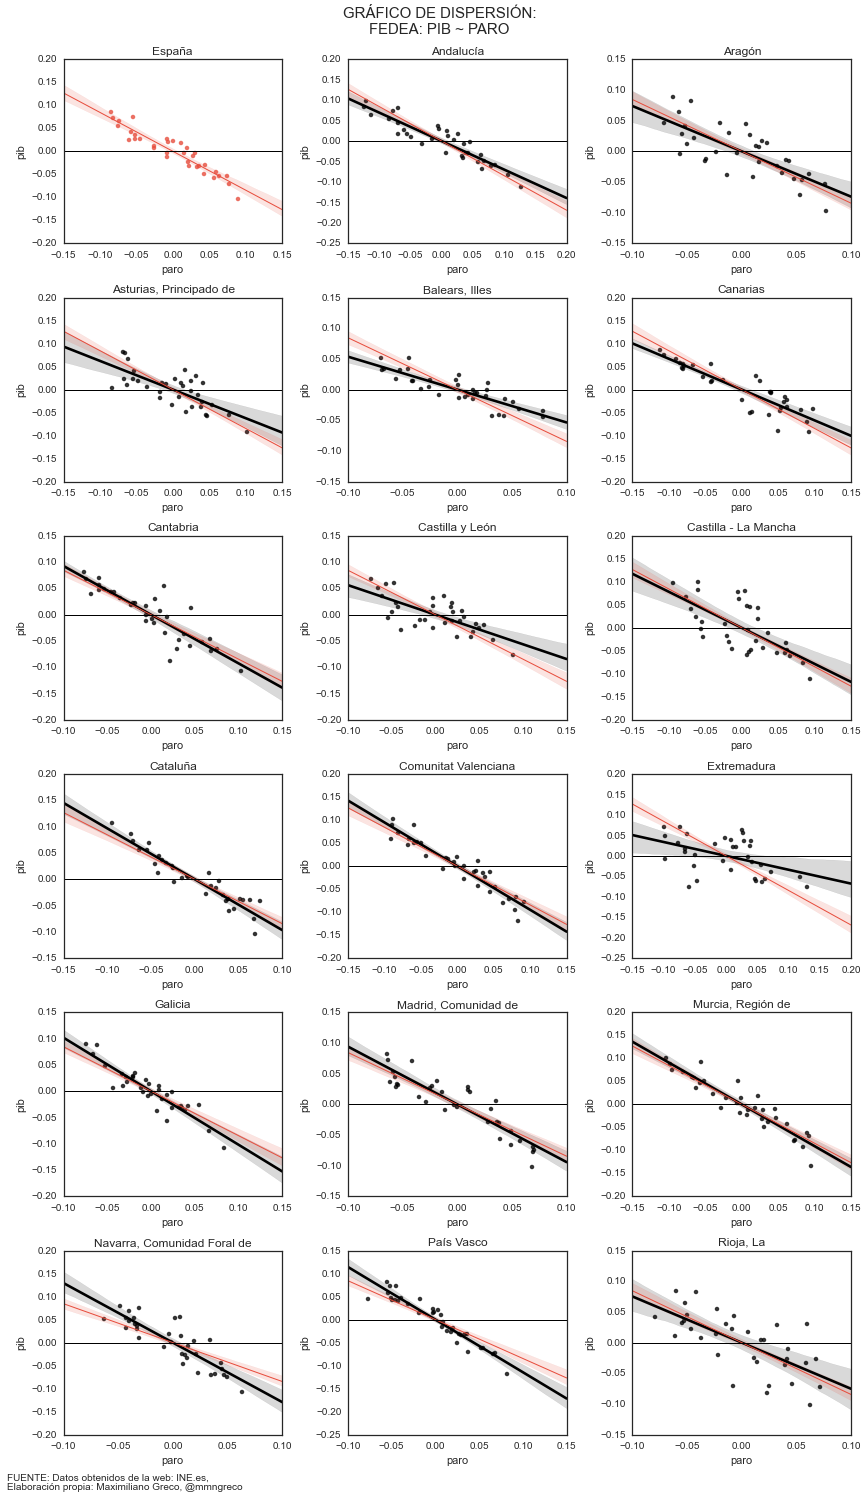

In [95]:
# PARAMETROS DEL GRÁFICO
id_x = 0
x = ['paro', 'empleo']
y = 'pib'

ttl = 'GRÁFICO DE DISPERSIÓN: \n%s: %s ~ %s' % (d_tipo.upper(), y.upper(), x[id_x].upper())
file_name = 'reg%s_%s_%s_%s.png' % (x[id_x].upper(), y.upper(), d_tipo, hoy)


######## 

fig = plt.figure(figsize=(12,20))

for i, reg in enumerate(regiones):
    if reg == 'España':
        ax = fig.add_subplot(len(regiones)/3, 3, i + 1)
        g = sns.regplot(y=data[y][reg], x=data[x[id_x]][reg], ax=ax, color="#e74c3c", line_kws={'linewidth': 1})
        plt.axhline(y=0, color='black', linewidth=1)

    else:
        ax = fig.add_subplot(len(regiones)/3, 3, i + 1)
        g = sns.regplot(y=data[y][reg], x=data[x[id_x]][reg], ax=ax, color='black')
        sns.regplot(y=data[y]['España'], 
                    x=data[x[id_x]]['España'], 
                    ax=ax, 
                    color="#e74c3c", 
                    scatter=False, 
                    line_kws={'linewidth': 1})
        plt.axhline(y=0, color='black', linewidth=1)
    g.set_xlabel(x[id_x])
    g.set_ylabel(y)
    g.set_title(reg)

plt.gcf().text(0, -0.01, "%s" % foot, fontsize=10, transform=(1,1))
plt.tight_layout()
plt.suptitle(t=ttl, fontsize=15, x=0.5, y=1.02)

plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

In [122]:
hp_productividad.head()

,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1980,-0.078996,-0.079871,-0.063634,-0.093496,-0.188299,-0.100374,-0.097249,-0.069149,-0.051362,-0.088173,-0.092975,-0.073477,-0.046595,-0.059734,-0.054505,-0.039555,-0.073169,-0.166377
1981,-0.066959,-0.086777,-0.068347,-0.099552,-0.145298,-0.085134,-0.068129,-0.094844,-0.072190,-0.066977,-0.056461,-0.123226,-0.008213,-0.036549,-0.118414,-0.011192,-0.051055,0.031186
1982,-0.061866,-0.078683,-0.074182,-0.031675,-0.092871,-0.103719,-0.063801,-0.055718,-0.100442,-0.053216,-0.035786,-0.102995,-0.036798,-0.067389,-0.061355,-0.047129,-0.045051,0.007292
1983,-0.045724,-0.040725,-0.043439,-0.079846,-0.041885,-0.046347,-0.064135,-0.058152,-0.090036,-0.051728,-0.014521,-0.094369,-0.057712,-0.030443,-0.056539,-0.035499,-0.036588,0.059582
1984,-0.006926,0.000540,0.005592,-0.055608,-0.043536,-0.002673,-0.022859,0.010470,-0.033284,-0.015093,0.034375,0.047344,-0.022669,0.003514,-0.044028,-0.010674,-0.029578,0.072000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c1fd630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12cf09198>]], dtype=object)

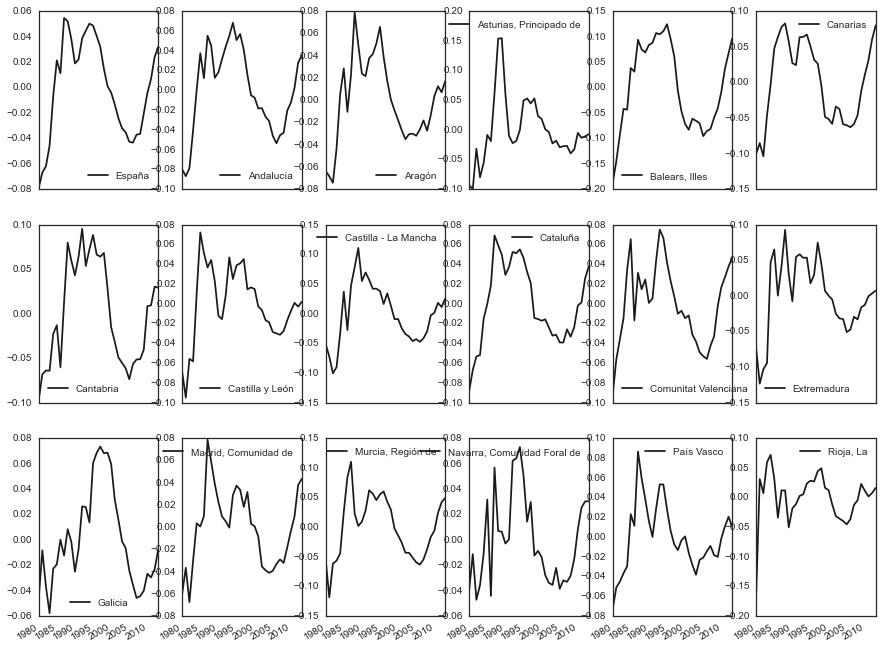

In [124]:
hp_productividad.plot(subplots=True, figsize=(15,12), layout=(3,6))

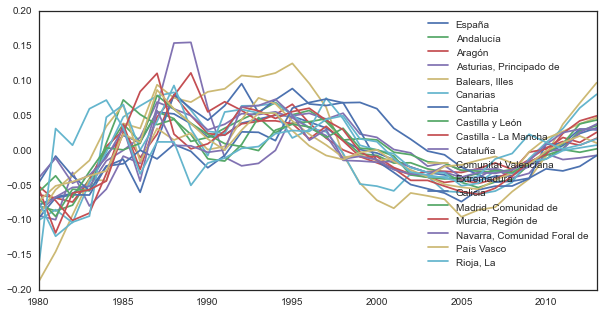

In [128]:
hp_productividad.plot(figsize=(10,5))

# BIBLIOGRAFÍA:

- [Estadisticas Robustas](link1)
- [Correlación de Pearson](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient)
- [Ley de Okun](https://es.wikipedia.org/wiki/Ley_de_Okun)
- [Okun's Law](https://en.wikipedia.org/wiki/Okun%27s_law)
- [How useful is Okun's Law](https://www.kansascityfed.org/publicat/econrev/pdf/4q07knotek.pdf)
- [Interpreting Deviations from Okun’s Law](http://www.frbsf.org/economic-research/publications/economic-letter/2014/april/okun-law-deviation-unemployment-recession/)
- [Do Forecasters Believe in Okun’s Law? An Assessment of Unemployment and Output Forecasts](https://www.imf.org/external/pubs/ft/wp/2014/wp1424.pdf)
- [Criterio de Outliers](https://es.wikipedia.org/wiki/Valor_at%C3%ADpico)


[link1]:https://en.wikipedia.org/wiki/Robust_statistics#Definition

# TEORÍA

- [Ley de Okun](https://es.wikipedia.org/wiki/Ley_de_Okun)
- [Okun's Law](https://en.wikipedia.org/wiki/Okun%27s_law)
- [How useful is Okun's Law](https://www.kansascityfed.org/publicat/econrev/pdf/4q07knotek.pdf)
- [Interpreting Deviations from Okun’s Law](http://www.frbsf.org/economic-research/publications/economic-letter/2014/april/okun-law-deviation-unemployment-recession/)
- [Do Forecasters Believe in Okun’s Law? An Assessment of Unemployment and Output Forecasts](https://www.imf.org/external/pubs/ft/wp/2014/wp1424.pdf)


# Apéndice:

# Markdown Sintaxis:
- [Footnote](http://rephrase.net/box/word/footnotes/syntax/)
- [Sintaxis, guía](http://daringfireball.net/projects/markdown/syntax#link)

![](http://cdn.churchm.ag/wp-content/uploads/2014/01/markdown-cheatsheet.png)

# REGRESIÓN:

Método de estimación:
- MCO

## Statsmodels:
- [Get Started](http://statsmodels.sourceforge.net/devel/gettingstarted.html)
- [Regression](http://statsmodels.sourceforge.net/devel/regression.html)
- [QT-filter](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.tsatools.detrend.html?highlight=trend#statsmodels.tsa.tsatools.detrend)
- [HP-filter](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/tsa_filters.html?highlight=trend)

## Linear Regresion
- Linear Regression: [link](http://connor-johnson.com/2014/02/18/linear-regression-with-python/)
- HP filter: [link](http://link.springer.com/article/10.1007%2FBF01205950)
- Patsy Formula: [link](https://patsy.readthedocs.org/en/latest/formulas.html)

# Python

- [format](https://mkaz.com/2012/10/10/python-string-format/)

In [71]:
!open imgs

In [9]:
!subl3 .

In [32]:
def crea_link_md(texto, *texto_enlace):
    '''
    Crea enlace local con formato markdown para un string, o lista de string.
    '''
    if len(texto_enlace) > 0:
        texto_enlace = texto_enlace[0]
        if isinstance(texto, str):
            t = texto.replace(' ', '-')
            link = '[{}](#{})'.format(texto_enlace, t)
            print(t)
            print(link)
    #        return t, link
        elif isinstance(texto, list) and len(texto) == len(texto_enlace):
            ret = dict()
            for i, t in enumerate(texto):
                link = '[{}](#{})'.format(texto_enlace[i], t.replace(' ', '-'))
                ret[t] = link
            for k, v in ret.items():
                print(k)
                print(v)
    #        return ret
        else:
            print(len(texto) == len(texto_enlace), '{} != {}\n{}\t{}'.format(len(texto), len(texto_enlace), texto, texto_enlace))
    else:

        if isinstance(texto, str):
            t = texto.replace(' ', '-')
            link = '[](#{})'.format(t)
            print(t)
            print(link)
    #        return t, link
        elif isinstance(texto, list):
            ret = dict()
            for t in texto:
                link = '[](#{})'.format(t.replace(' ', '-'))
                ret[t] = link
            for k, v in ret.items():
                print(k)
                print(v)
    #        return ret




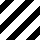
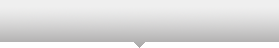
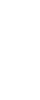
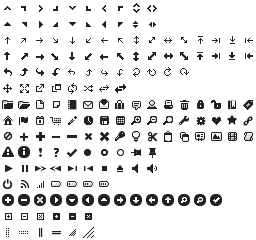
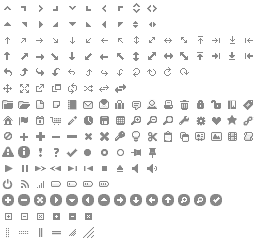
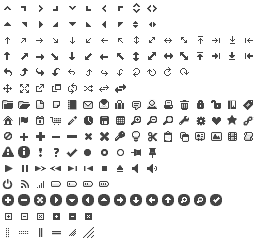
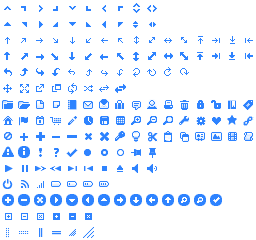
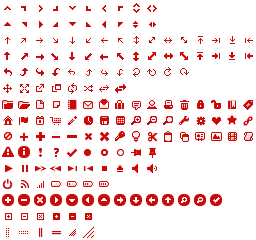
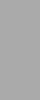
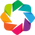
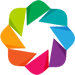
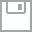
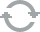
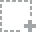
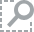
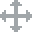
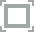
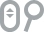

NameError: name 'ppl' is not defined

In [17]:
import bokeh.plotting as bkh
from bokeh import mpl

bkh.output_notebook()

ppl.plot(dwork.empleo, linewidth=3)
plt.xticks(dwork.index)
plt.legend(loc='upper left')
bkh.show(mpl.to_bokeh())

http://bokeh.pydata.org/en/latest/docs/reference/charts.html%23bokeh-charts

# GIT WORK-FLOW

In [40]:
pwd

'/Users/mmngreco/Documents/repos/okun_ccaa'

In [39]:
datetime.now()

datetime.datetime(2015, 9, 18, 9, 26, 45, 398069)

In [41]:
%%!
git add .
git commit -a -m 'update 9.18.0926'
git push origin master

['[master 7469bfa] update 9.18.0926',
 ' 5 files changed, 1367 insertions(+), 1488 deletions(-)',
 ' create mode 100644 imgs/evolucion_log~tasa_pib_b0_2015-09-18_09:06:40.827790.png',
 ' create mode 100644 imgs/evolucion_log~tasa_pib_b0_2015-09-18_09:06:40.827790_todas.png',
 ' create mode 100644 imgs/evolucion_log~tasa_pib_b1_2015-09-18_09:06:40.827790.png',
 ' create mode 100644 imgs/evolucion_log~tasa_pib_b1_2015-09-18_09:06:40.827790_todas.png',
 'To https://github.com/mmngreco/okun_ccaa.git',
 '   0e480a3..7469bfa  master -> master']

- [🏠INDICE: ](#INDICE)
- [📈MCO](#MCO) 
- [📊datos](#DATOS)
- [🔨FILTROS](#FILTROS)